In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np
import inspect

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info

In [3]:
print(inspect.getdoc(DCRemoval))
print('\n\nMain interface\n' + inspect.getdoc(DCRemoval.main))

Linear-phase DC Removal Filter
------------------------------

Sharp notch filter, peak-to-peak ripple of 0.42 dB.
Based on the Dual-MA system described in https://www.dsprelated.com/showarticle/58.php ,
Quad-MA is discussed but IMHO not worth the BRAM.

Args:
    window_len: Averaging window size, must be power of two. Controls the filter sharpness and the BRAM usage.
                Optimal value is 2048. 1024 may be good enough.
    dtype: Sfix or Complex (applies to real and imag channels separately)


Main interface
Args:
    input (DataValid): -1.0 ... 1.0 range, up to 18 bits

Returns:
    DataValid:  DC-free output, 18 bits(-1.0 ... 1.0 range). Saturates on overflow.
                Rounding it down to 12-bits (standard SDR IQ width) wont work,
                you need ~16 bits to reliably remove the DC-offset.


# Examples

## Remove DC component from complex signal

INFO:sim:Tracing is enabled, running "MODEL" and "PYHA" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 8192/8192 [00:00<00:00, 9878.11it/s] 

INFO:sim:Flushing the pipeline to collect 8192 valid samples (currently have 8187)
INFO:sim:Flush took 5 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


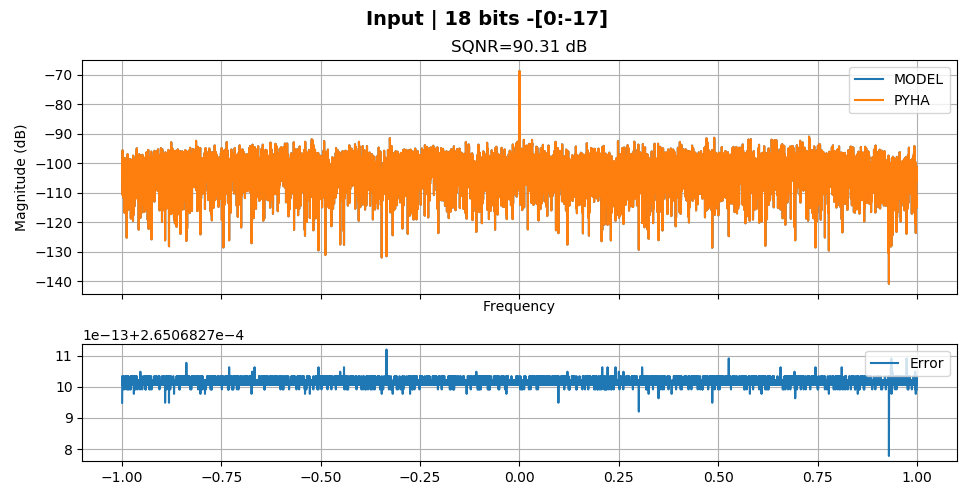

<IPython.core.display.Javascript object>


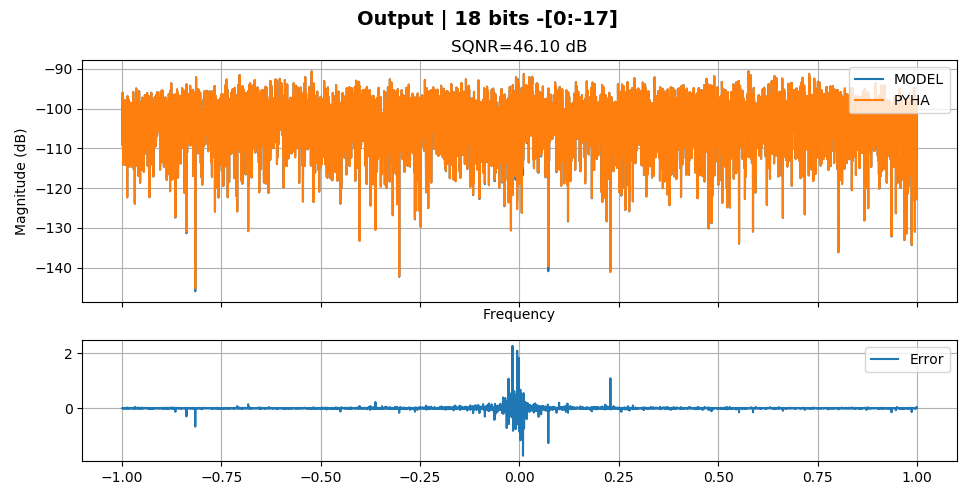

<IPython.core.display.Javascript object>


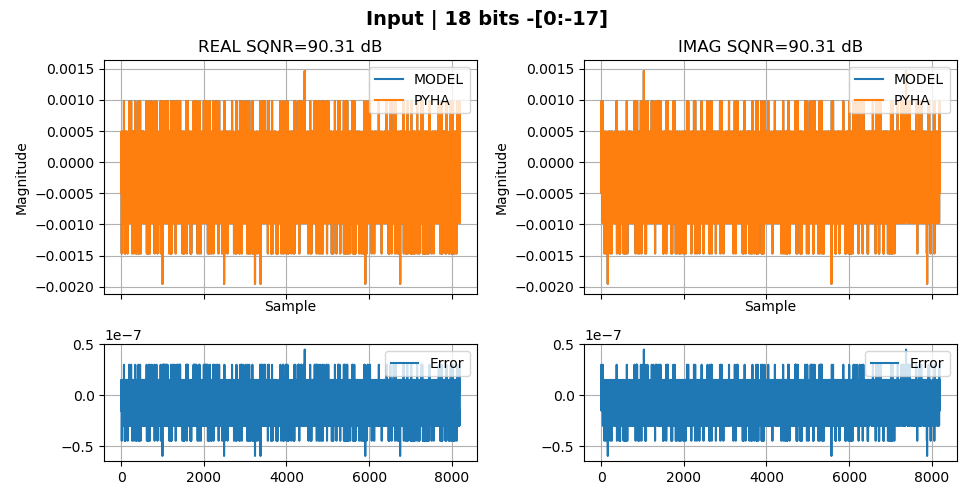

<IPython.core.display.Javascript object>


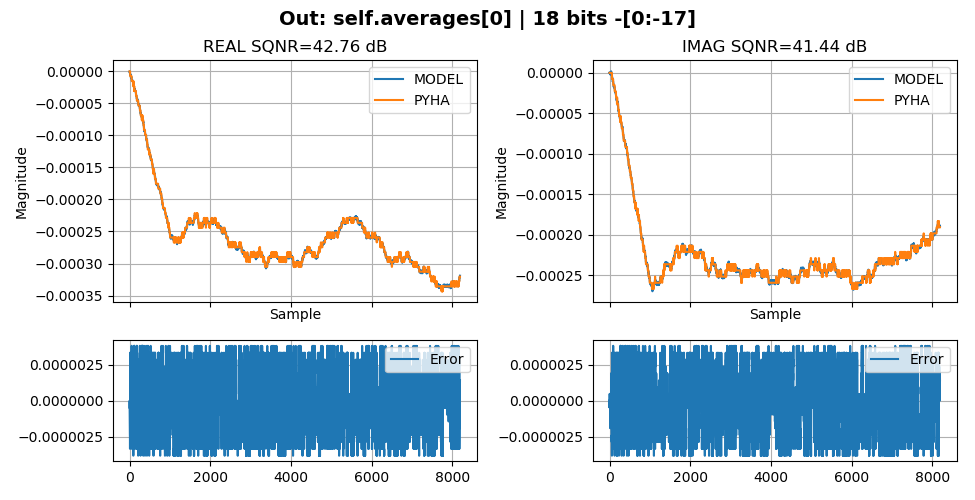

<IPython.core.display.Javascript object>


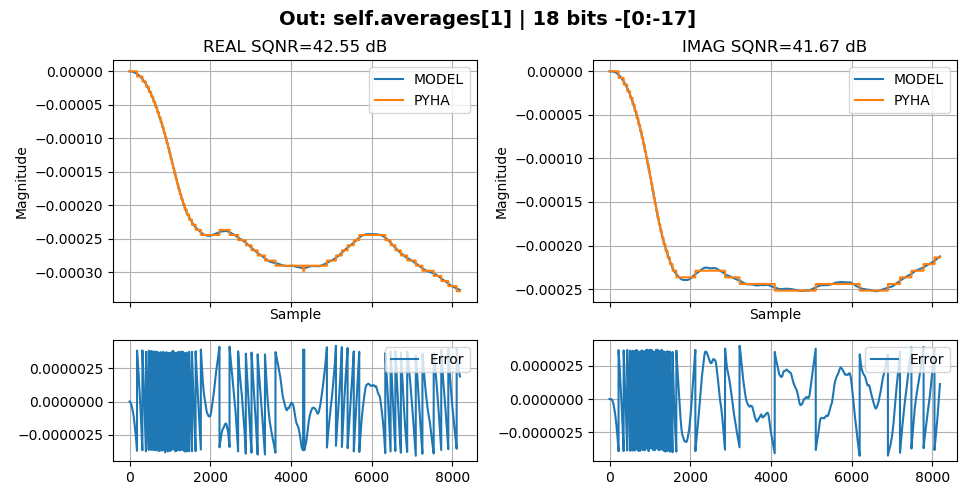

<IPython.core.display.Javascript object>


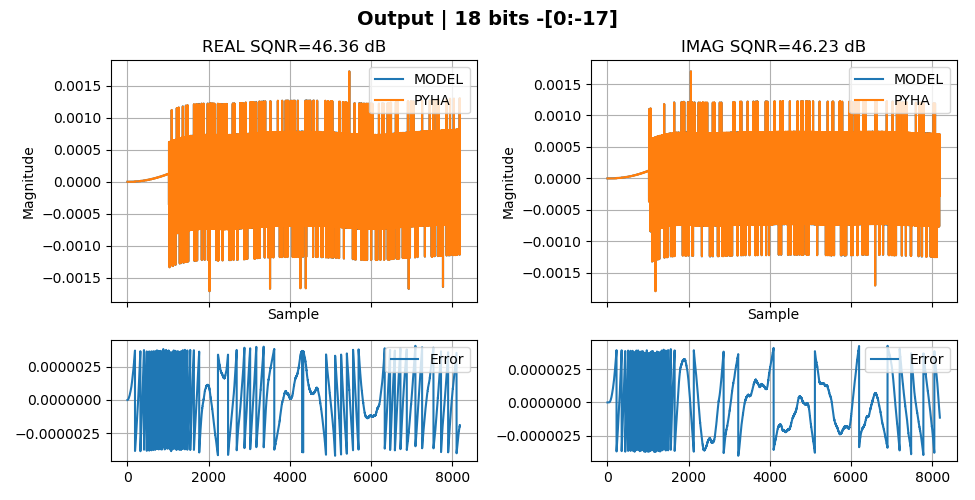

In [4]:
file = get_data_file('limem_ph3weak_40m')
input_signal = load_complex64_file(file)[:1024*8] # load your own IQ samples here!

dut = DCRemoval(window_len=1024)
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto') # run simulations and gather trace

plot_trace_input_output(plotter=plot_frequency_domain)
plot_trace()

## Frequency response

INFO:sim:Tracing is enabled, running "MODEL" and "PYHA" simulations
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Running "PYHA" simulation...


100%|██████████| 16384/16384 [00:01<00:00, 9956.21it/s]

INFO:sim:Flushing the pipeline to collect 16384 valid samples (currently have 16379)
INFO:sim:Flush took 5 cycles.
INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


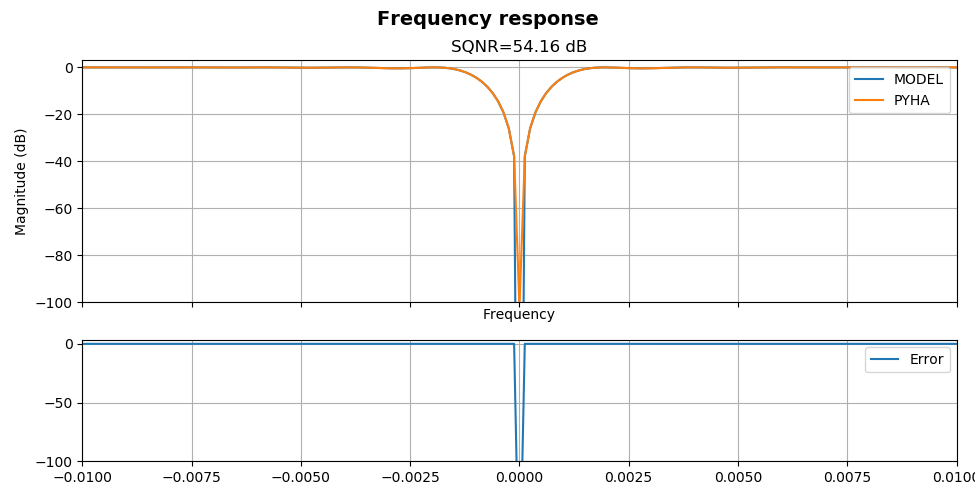

In [5]:
input_signal = [0.0 + 0.0j] * 1024 * 16
input_signal[0] = 1.0 + 1.0j
dut = DCRemoval(window_len=1024)
sims = simulate(dut, input_signal, trace=True, pipeline_flush='auto') # run simulations and gather trace
plot_frequency_response(sims, xlim=[-0.01, 0.01], ylim=[-100, 3])

# Conversion to VHDL and RTL/NETLIST simulations

In [8]:
# Pyha supports running 'RTL' (using GHDL) and 'GATE' (netlist after quartus_map) level simulations.
output_dir = '~/Documents/pyha_output'
input_signal = np.random.normal(size=1024) * 0.25
dut = DCRemoval(window_len=1024)
sims = simulate(dut, input_signal, pipeline_flush='auto', simulations=['MODEL', 'PYHA', 'RTL', 'GATE'], conversion_path=output_dir)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1024/1024 [00:00<00:00, 1638.20it/s]

INFO:sim:Flushing the pipeline to collect 1024 valid samples (currently have 1019)
INFO:sim:Flush took 5 cycles.
INFO:sim:OK!
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...


INFO:conversion:MovingAverage to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DCRemoval to VHDL ...
INFO:conversion:Took 0.57 seconds
INFO:sim:Running "RTL" simulation...
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 1029/1029 [00:01<00:00, 568.63it/s]

INFO:sim:OK!
INFO:sim:Running "NETLIST" simulation...
INFO:synth:Running quartus_map quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
INFO:synth:Running quartus_eda quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
loading VPI module '/cocotb/build/libs/x86_64/libvpi.so'
VPI module loaded!
100%|##########| 1029/1029 [00:09<00:00, 113.05it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


# Synthesis:  resource usage and Fmax

In [7]:
quartus = get_simulator_quartus() # reuse the work that was done during the simulation
print(quartus.get_resource_usage('fit'))
print(quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 573 / 39,600 ( 1 % )
    Total combinational functions : 429 / 39,600 ( 1 % )
    Dedicated logic registers : 411 / 39,600 ( 1 % )
Total registers : 411
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 73,548 / 1,161,216 ( 6 % )
Embedded Multiplier 9-bit elements : 0 / 232 ( 0 % )
Total PLLs : 0 / 4 ( 0 % )



/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory


+--------------------------------------------------+
; Fmax Summary                                     ;
+------------+-----------------+------------+------+
; Fmax       ; Restricted Fmax ; Clock Name ; Note ;
+------------+-----------------+------------+------+
; 179.05 MHz ; 179.05 MHz      ; clk        ;      ;
+------------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by the same clock.  Paths of different clocks, including generated clocks, are ignored.  For paths between a clock and its inversion, FMAX is computed as if the rising and falling edges are scaled along with FMAX, such that the duty cycle (in terms of a percentage) is maintained. Altera recommends that you always use clock constraints and other slack reports for sign-off analysis.

